In [1]:
device="cpu"
import io
import torch
import torch.nn as nn
import PIL.Image
import einops
import matplotlib.pyplot as plt
import numpy as np
import datasets
import math
from IPython.display import HTML
from types import SimpleNamespace
from timm.optim import Mars
from fastprogress import progress_bar, master_bar
from torchvision.transforms.v2 import ToPILImage, PILToTensor, CenterCrop, RandomCrop
from timm.models.efficientvit_mit import GELUTanh, EfficientVitBlock, ResidualBlock, build_local_block
from pytorch_wavelets import DWTForward, DWTInverse
from tft.wavelet import WPT3D, IWPT3D
from tft.utils import compand, decompand
dataset = datasets.load_dataset("danjacobellis/organmnist3d_64")

In [2]:
config = SimpleNamespace()
config.F = 8
config.target_bits_per_channel = np.log2(7)
config.latent_dim = 128;
config.channels = 1
config.max_noise_penalty = 1e-5
config.encoder_depth = 6
config.max_lr = 1e-3
config.min_lr = config.max_lr / 1e3
config.lr_pow = 2
config.volume_size = 48
config.batch_size = 64
config.num_workers = 32
config.epochs = 24
config.total_steps = config.epochs * (dataset['train'].num_rows // config.batch_size)

In [46]:
from transforms import RandomCrop3D
rand_crop = RandomCrop3D(config.volume_size)
def pil_to_grid3d(img):
    x = torch.tensor(np.array(img))
    x = einops.rearrange(x, '(a y) (b z) c -> (a b c) y z', a=4, b=4, c=4)
    return x
def collate_fn(batch):
    return torch.cat([
        rand_crop(pil_to_grid3d(sample['image']).unsqueeze(0).unsqueeze(0)) for sample in batch
    ]).to(torch.float)/127.5 - 1.0

In [47]:
batch = dataset['train'].select(range(2))
x = collate_fn(batch)

In [48]:
x.shape

torch.Size([2, 1, 48, 48, 48])

In [5]:
model = AutoEncoder2D(
    channels=config.channels,
    J = int(config.F**0.5),
    latent_dim=config.latent_dim,
    total_scale=2**(8.0-config.target_bits_per_channel),
    num_res_blocks=config.encoder_depth
).to(device)

print(f"{sum(p.numel() for p in model.parameters())/1e6} M parameters")

optimizer = Mars(model.parameters(), lr=1.0, caution=True)

def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr

schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)

56.68536 M parameters


In [6]:
def collate_fn(batch):
    return torch.cat([
        PILToTensor()(
            RandomCrop(config.img_size)(sample['image'])
        ).unsqueeze(0) for sample in batch
    ]).to(torch.float)/127.5 - 1.0

In [ ]:
learning_rates = [optimizer.param_groups[0]['lr']]
mb = master_bar(range(config.epochs))
losses = []
for i_epoch in mb:
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
            dataset['train'],
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            drop_last=True,
            shuffle=True,
            collate_fn=collate_fn
        )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, x in enumerate(pb):
        x = x.to(device)

        x_hat = model(x)
     
        loss = torch.nn.functional.mse_loss(x, x_hat) 
        losses.append(loss.item())
        loss += config.max_noise_penalty*model.noise_injection.noise_scales().max()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        schedule.step()
        learning_rates.append(optimizer.param_groups[0]['lr'])
    
        pb.comment = f"PSNR: {-10*np.log10(losses[-1]).item()+6.02:.3g}, LR: {learning_rates[-1]:.3g}"

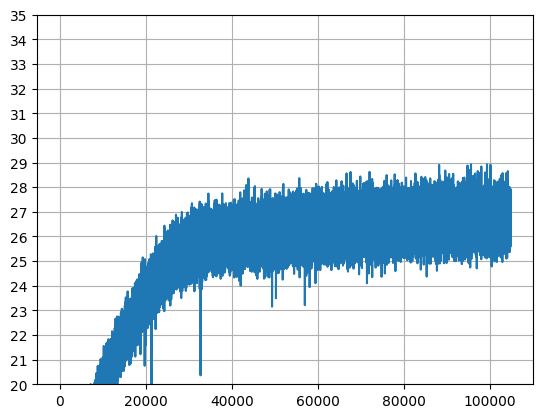

In [8]:
display(HTML(mb.main_bar.progress))
display(HTML(pb.progress))
plt.plot(-10*np.log10(losses)+6.02)
plt.yticks(range(20,36));
plt.ylim([20,35])
plt.grid()

25.872 KB
30.397031539888683x compression ratio
16.0x dimension reduction
26.991133708953857 dB PSNR


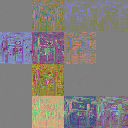

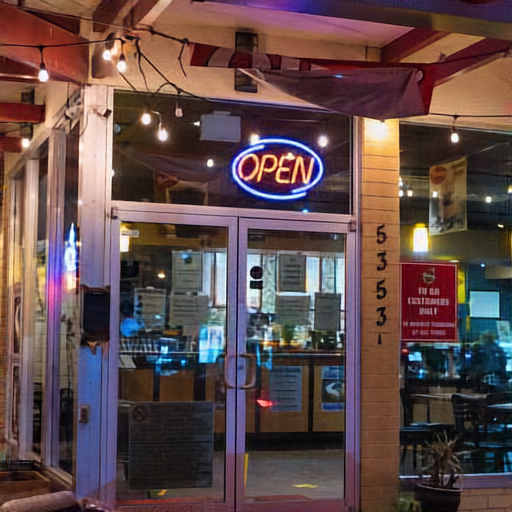

In [9]:
from walloc.walloc import latent_to_pil, pil_to_latent
model.eval()
config.img_size=512
img = CenterCrop(config.img_size)(dataset['validation'][28]['image'])
x = PILToTensor()(img).to(device).unsqueeze(0).to(torch.float) / 127.5 - 1.0
x_orig = x[0]
orig_dim = x.numel()
with torch.no_grad():
    latent = model.encode(x)
webp = latent_to_pil(latent.cpu(),n_bits=8, C=3)
buff = io.BytesIO()
webp[0].save(buff, format='WEBP', lossless=True)
size_bytes = len(buff.getbuffer())
print(f"{size_bytes/1e3} KB")
print(f"{orig_dim/size_bytes}x compression ratio")
print(f"{orig_dim/latent.numel()}x dimension reduction")
latent_decoded = pil_to_latent(webp, N=config.latent_dim, n_bits=8, C=3).to(device)
with torch.no_grad():
    x_hat = model.decode(latent_decoded)
mse = torch.nn.functional.mse_loss(x,x_hat)
PSNR = -10*mse.log10().item() + 6.02
print(f"{PSNR} dB PSNR")

display(webp[0])
ToPILImage()(x_hat[0].clamp(-1,1)/2+0.5)

(107.0, 147.0)

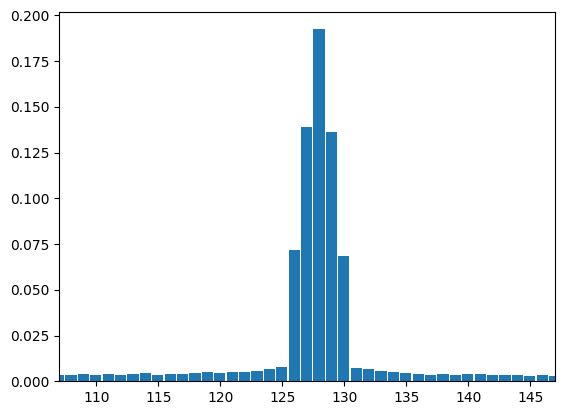

In [10]:
plt.hist(np.array(webp[0]).flatten(),bins=256,range=(-0.5,255.5),width=0.9,density=True);
plt.xlim([127-20,127+20])

tensor(4.4922)


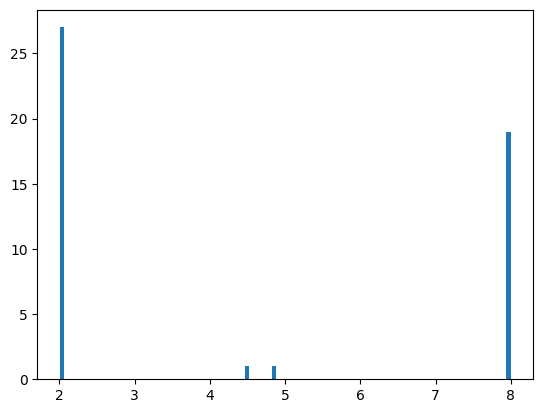

In [12]:
bits_per_channel = (8 - model.noise_injection.noise_scales().detach().log2()).cpu()
print(bits_per_channel.mean())
plt.hist(bits_per_channel,bins=100);

26.694000244140625 PSNR
28K	test.jpg


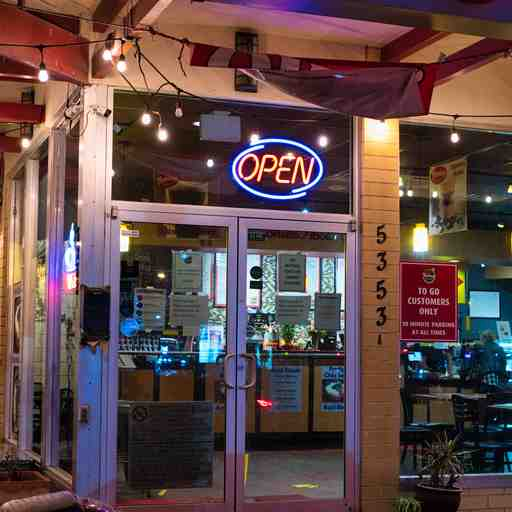

In [14]:
img.crop((0,0,config.img_size,config.img_size)).save("test.jpg",quality=25)
jpeg = PIL.Image.open("test.jpg")
MSE = torch.nn.functional.mse_loss(PILToTensor()(jpeg).to(torch.float)/255, x_orig.to("cpu")/2 + 0.5)
print(f"{-10*MSE.log10()} PSNR")
!du -sh test.jpg
display(jpeg)